In [1]:
# Author: gsanch
# Date: 26/11/2023
# Version: 1.0

# 6th Novartis Datathon 2023

The objective of the competition is to develop a model capable of predicting daily sales phasing—specifically, the percentage of a certain workday's (Monday to Friday) sales relative to the monthly total—for each country and brand. The provided data include date fields and brand characteristics for each country.

### Data Cleaning
The initial step is data cleaning, which is the first step and primary focus of this notebook.

In [2]:
# IMPORTS

import pandas as pd
import seaborn as sns
import missingno as msno #Visualize NaN on DataFrame
import matplotlib.pyplot as plt
from thefuzz import fuzz #To detect possible mistakes in strings
import numpy as np
import math
import warnings

In [3]:
# Run to display all the columns or rows of the DataFrame

#pd.reset_option('display.max_rows')
pd.set_option('display.max_columns',None)

In [4]:
# Source data
df = pd.read_parquet('~/Github/novartis-datathon/data/train_data.parquet', engine='pyarrow')
df

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
0,AIMST,0.006284,Aldovia,2.0,1.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN
1,AIMST,0.123459,Aldovia,3.0,1.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN
2,AIMST,0.055607,Aldovia,4.0,1.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN
3,AIMST,0.032148,Aldovia,0.0,1.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN
4,AIMST,0.097054,Aldovia,1.0,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525877,ZVLFE,0.010716,Zamunda,0.0,9.0,0.818182,M,NaN,2.0,0.0,4,4,4,5,5,2016-09-26,18,4,0.010540,NaN
3525878,ZVLFE,0.042210,Zamunda,1.0,9.0,0.863636,M,NaN,0.0,0.0,4,4,4,5,5,2016-09-27,19,3,0.010540,NaN
3525879,ZVLFE,0.051639,Zamunda,2.0,9.0,0.909091,M,NaN,0.0,0.0,4,4,4,5,5,2016-09-28,20,2,0.010540,NaN
3525880,ZVLFE,0.065464,Zamunda,3.0,9.0,0.954545,M,NaN,0.0,0.0,4,4,4,5,5,2016-09-29,21,1,0.010540,NaN


In [5]:
# CONSTANT for keeping the cols of the source data
original_cols = list(df.columns)
original_cols

['brand',
 'phase',
 'country',
 'dayweek',
 'month',
 'wd_perc',
 'ther_area',
 'hospital_rate',
 'n_nwd_bef',
 'n_nwd_aft',
 'n_weekday_0',
 'n_weekday_1',
 'n_weekday_2',
 'n_weekday_3',
 'n_weekday_4',
 'date',
 'wd',
 'wd_left',
 'monthly',
 'main_channel']

# Exploratory analysis

In [6]:
# No duplicate records
df[df.duplicated()].size

0

In [7]:
# Visualizing dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2812490 entries, 0 to 3525881
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   brand          object        
 1   phase          float64       
 2   country        object        
 3   dayweek        float64       
 4   month          float64       
 5   wd_perc        float64       
 6   ther_area      category      
 7   hospital_rate  float64       
 8   n_nwd_bef      float64       
 9   n_nwd_aft      float64       
 10  n_weekday_0    int64         
 11  n_weekday_1    int64         
 12  n_weekday_2    int64         
 13  n_weekday_3    int64         
 14  n_weekday_4    int64         
 15  date           datetime64[us]
 16  wd             int64         
 17  wd_left        int64         
 18  monthly        float64       
 19  main_channel   category      
dtypes: category(2), datetime64[us](1), float64(8), int64(7), object(2)
memory usage: 413.1+ MB


In [8]:
# Main characteristics of the DataFrame

nunique_list = []
unique_list = [] 
n_nan_list = [] # Store percentage of NaN records in each col
n_rec = df.shape[0]

for col in original_cols:
    #NaN values
    n_nan = df[col].isna().sum()
    n_nan_list.append(n_nan/n_rec)
    #Values and n of values
    nunique_list.append(df[col].nunique())
    unique_list.append(df[col].unique())

nunique_col_df = pd.DataFrame({'column':original_cols,\
                               'nunique':nunique_list,\
                               'unique':unique_list,\
                               '%_nans':n_nan_list}).sort_values('nunique')

# Merge with dtype info
nunique_dtype_df = nunique_col_df.merge(df.dtypes.reset_index(),\
                                        left_on='column',\
                                        right_on='index').drop('index',axis=1).rename({0:'dtype'},axis=1)
nunique_dtype_df

,column,nunique,unique,%_nans,dtype
0,main_channel,4,"[NaN, 'RETAIL', 'HOSPITAL', 'OTHERS', 'COMBINE...",0.179554,category
1,dayweek,7,"[2.0, 3.0, 4.0, 0.0, 1.0, 6.0, 5.0]",0.000000,float64
2,month,12,"[1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",0.000000,float64
3,n_weekday_2,14,"[5, 4, 3, 8, 10, 9, 6, 7, 12, 15, 11, 13, 14, 2]",0.000000,int64
4,ther_area,14,"[NaN, 'S', 'G', 'M', 'J', ..., 'D', 'H', 'V', ...",0.126736,category
5,n_weekday_1,14,"[4, 5, 3, 10, 8, 6, 9, 7, 13, 12, 11, 14, 15, 2]",0.000000,int64
6,n_weekday_0,14,"[4, 3, 5, 10, 8, 7, 6, 9, 15, 12, 13, 14, 11, 2]",0.000000,int64
7,n_weekday_3,15,"[5, 4, 3, 8, 10, 6, 7, 9, 12, 15, 13, 14, 11, ...",0.000000,int64
8,n_weekday_4,16,"[4, 5, 3, 7, 8, 10, 6, 9, 15, 12, 14, 11, 13, ...",0.000000,int64
9,n_nwd_aft,18,"[0.0, 2.0, 5.0, 1.0, 3.0, 4.0, 8.0, 6.0, 10.0,...",0.000000,float64


In [9]:
# Other relevant info
df_describe = df.describe()
for col in df_describe.columns:
    if df_describe[col].dtype == float:
        df_describe[col] = df_describe[col].apply(round,args=(2,))
df_describe = df_describe.replace(0,'')
df_describe

,phase,dayweek,month,wd_perc,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly
count,2812490.0,2812490.0,2812490.00,2812490.00,2307496.0,2812490.0,2812490.0,2812490.00,2812490.00,2812490.00,2812490.0,2812490.0,2812490,2812490.00,2812490.0,2812490.0
mean,0.05,2.02,6.56,0.52,0.25,0.62,0.38,5.92,6.25,6.26,6.13,5.95,2017-07-11 21:30:44.473759,10.86,9.85,0.05
min,,,1.00,0.04,,,,2.00,2.00,2.00,,,2013-01-01 00:00:00,1.00,,
25%,0.01,1.0,4.00,0.27,,,,4.00,4.00,4.00,4.0,4.0,2015-05-13 00:00:00,6.00,5.0,0.01
50%,0.03,2.0,7.00,0.52,0.03,,,5.00,5.00,5.00,5.0,5.0,2017-08-01 00:00:00,11.00,10.0,0.03
75%,0.07,3.0,9.00,0.77,0.34,,,8.00,8.00,8.00,8.0,8.0,2019-09-12 00:00:00,16.00,15.0,0.06
max,0.92,6.0,12.00,1.00,1.0,23.0,20.0,15.00,15.00,15.00,15.0,15.0,2021-12-31 00:00:00,27.00,26.0,1.0
std,0.06,1.43,3.40,0.29,0.37,1.46,1.01,2.77,2.83,2.85,2.84,2.91,NaN,6.05,6.05,0.06


Here's the translation to English:

## Column Observations

- **main_channel**
    - (2 - Handle NaNs)
- **dayweek**
    - (0 - Delete records) Values 5 and 6 will harm the model because we are working with weekdays
- **month**
    - We will assume the data is correct (do not check against the date column)
- **n_weekday_x**
    - (1 - Correct records) Impossible values. They can never be more than 5 (no more than 5 Mondays, Tuesdays, etc., workdays per month). We derive the correct values by following this strategy:
        - Order as we will group: year, month, country
        - Visualization of the problem (erroneous values)
        - Group by country, year, month, and dayweek
        - Count the number of records. We know all records are for weekdays.
        - Create a pivot_table with respect to dayweek
        - Impute the obtained values to the original df
        - Check for possible deviations caused by the update of values:
            - Calculate the sum of weekdays (Monday + Tuesday +...)
            - Calculate max(wd) for each grouping of year, month, and country
            - Ensure the sum of weekdays is equal to max(wd) for each group
            - For those records where this is not the case, perform (5 - Exploratory analysis)
- **ther_area**
    - (2 - Handle NaNs) The same medicine will always belong to the same treatment category
- **n_nwd_aft**
    - Number of consecutive non-working days starting from a certain day.
    - There are very strange data (20, for example)
    - (6 - Check constraint)
        - Group by country, date
        - Order by date
        - Check: Current Date record + n_nwd_aft + 1 = Date of next record
- **n_nwd_bef**
    - Number of consecutive non-working days enjoyed until the present day.
    - (6 - Check constraint)
        - Group by country, date
        - Order by date
        - Check: Current Date record - (n_nwd_aft + 1) = Date of previous record
- **wd**
    - Workdays elapsed since the beginning of the month
    - max(wd) grouped by month, year, and country indicates the number of workdays in the month
    - (6 - Check constraint)
        - Each group must have an uninterrupted sequence of numbers between 1 and max(wd)
- **wd_left**
    - Remaining workdays of the month.
    - (6 - Check constraint)
        - wd_left + wd = max(wd)
- **country**
    - Convert to categorical type
- **wd_perc**
    - Percentage of workdays elapsed in the current month
    - (6 - Constraint)
        - Multiplied by max(wd) should give wd for each record.
- **brand**
    - Check for possible transcription errors
- **hospital_rate**
    - (2 - Handle NaNs)
- **date**
    - Create a year column from this
    - (6 - Check) extract month and weekday and compare with values.
- **phase**
    - (6 - Check constraint) Verify that they sum to 1 for each grouping of country, year, month, brand

In [10]:
# 1.1. Calculate year col
df['year'] = pd.to_datetime(df['date']).dt.year
df = df.sort_values(['year','month','country','brand'])
df

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel,year
0,AIMST,0.006284,Aldovia,2.0,1.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN,2013
1,AIMST,0.123459,Aldovia,3.0,1.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN,2013
2,AIMST,0.055607,Aldovia,4.0,1.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN,2013
3,AIMST,0.032148,Aldovia,0.0,1.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN,2013
4,AIMST,0.097054,Aldovia,1.0,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521036,ZKKLD,0.049943,Zamunda,3.0,12.0,0.789474,R,0.00088,0.0,3.0,4,4,3,5,3,2021-12-23,15,4,0.039834,RETAIL,2021
3521037,ZKKLD,0.033827,Zamunda,0.0,12.0,0.842105,R,0.00088,3.0,0.0,4,4,3,5,3,2021-12-27,16,3,0.039834,RETAIL,2021
3521038,ZKKLD,0.005815,Zamunda,1.0,12.0,0.894737,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-28,17,2,0.039834,RETAIL,2021
3521039,ZKKLD,0.000013,Zamunda,2.0,12.0,0.947368,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-29,18,1,0.039834,RETAIL,2021


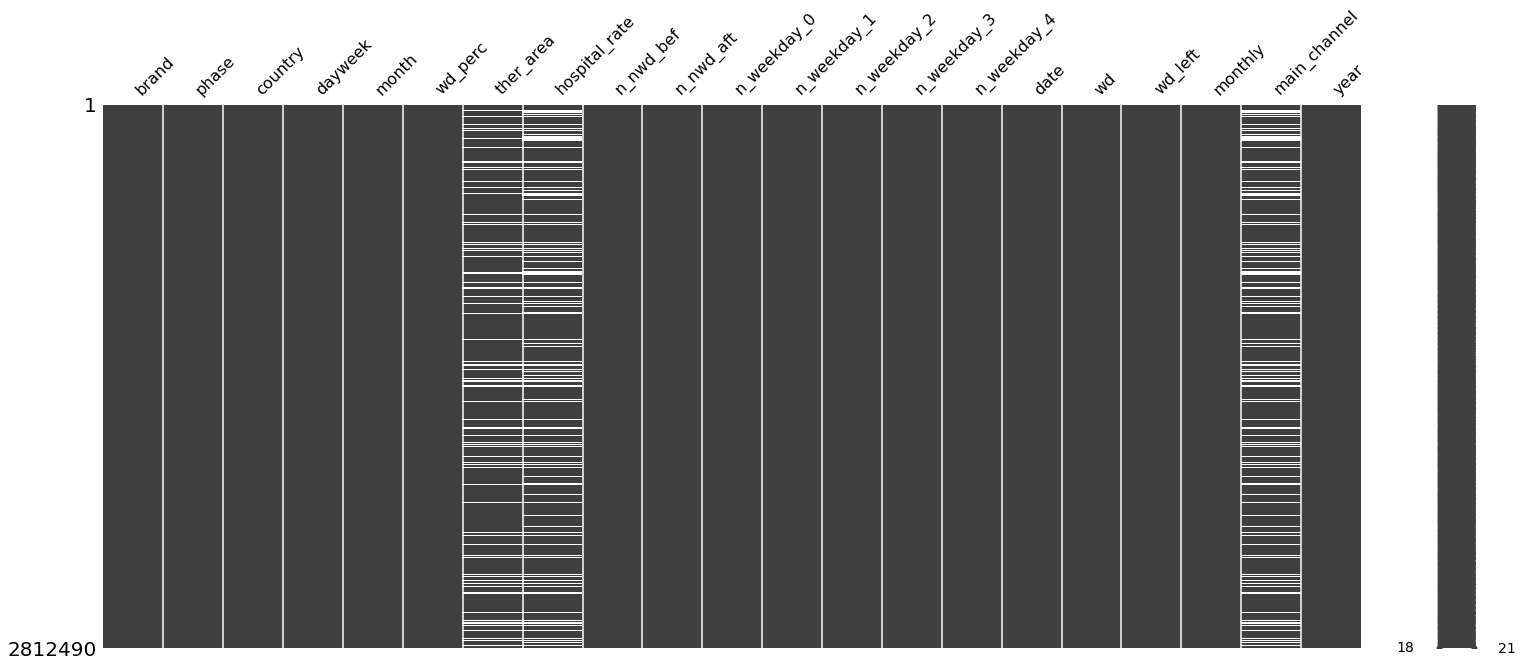

In [11]:
# Visualize missingness
msno.matrix(df)
plt.show()

<AxesSubplot:ylabel='index'>

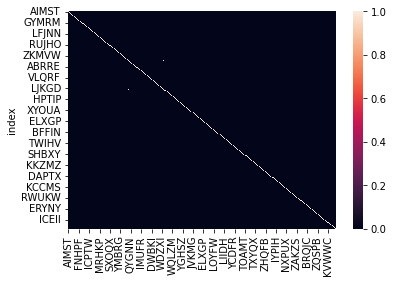

In [12]:
# Checking possible mistakes in brand name
brand_values = df['brand'].unique()
similarity_dicc = {'index':brand_values}
for b1 in brand_values:
    similarity = []
    for b2 in brand_values:
        similarity.append(fuzz.WRatio(b1,b2) > 70)
    similarity_dicc[b1] = similarity

brand_sim_df = pd.DataFrame(similarity_dicc).set_index('index')
sns.heatmap(brand_sim_df)

In [13]:
# Doesnt seem to be any mistake on brand name
dicc_enum_brand = {index:brand for index,brand in enumerate(brand_values)}
fila, columna = np.where(brand_sim_df == 1)
sim_list = []

for i in range(len(fila)):
    if fila[i] != columna[i]:
        sim_list.append((dicc_enum_brand[fila[i]],dicc_enum_brand[columna[i]]))

sim_dicc = {}
for b_tuple in sim_list:
    sim_dicc[b_tuple[0]] = df['brand'].value_counts().loc[b_tuple[0]]
    
sim_dicc

{'MZCGA': 5133, 'MNZCG': 7216}

<AxesSubplot:ylabel='index'>

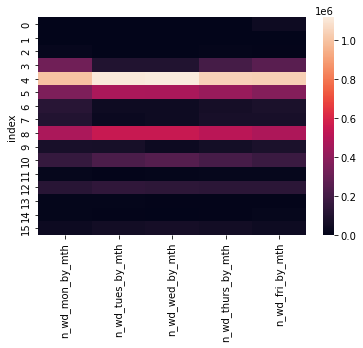

In [14]:
# Visualizing outliers in n_weekday cols

n_weekday_cols = df.columns[df.columns.str.startswith('n_weekday')]
max_n_weekday = max(df.describe().loc['max',n_weekday_cols])
index_n = list(range(0,int(max_n_weekday)+1))
n_weekday_dict = {'index':index_n}

for col in n_weekday_cols:
    indexes = df[col].value_counts().index
    add_indexes = [i for i in index_n if i not in indexes]
    value_count = df[col].value_counts()
    for index in add_indexes:
        value_count.loc[index] = 0
    n_weekday_dict[col] = value_count

rename_cols = {'n_weekday_0':'n_wd_mon_by_mth',
               'n_weekday_1':'n_wd_tues_by_mth',
               'n_weekday_2':'n_wd_wed_by_mth',
               'n_weekday_3':'n_wd_thurs_by_mth',
               'n_weekday_4':'n_wd_fri_by_mth'}

n_weekday_df = pd.DataFrame(n_weekday_dict).rename(rename_cols,axis=1).set_index('index')

sns.heatmap(n_weekday_df)
# It shouldn't be lighted for values >5

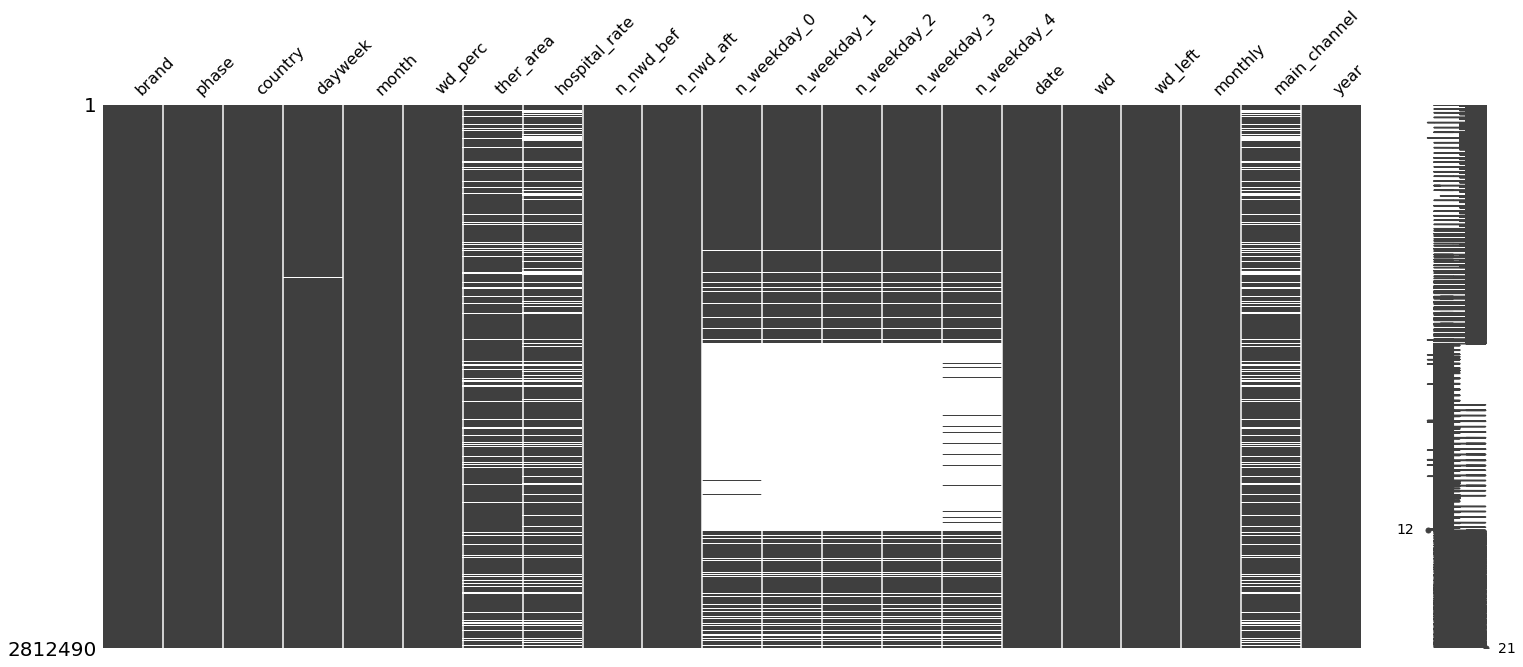

In [15]:
# Turn to NaN to visualize mistakes in n_weekday
df_for_nans = df.copy()
n_weekdays_rep_dic = dict(zip(range(6,16),[np.nan]*len(range(6,16))))
nan_weekday_cols = df_for_nans[n_weekday_cols].replace(n_weekdays_rep_dic)
nan_dayweek_cols = df_for_nans['dayweek'].replace({float(5):np.nan,float(6):np.nan})
df_for_nans[n_weekday_cols] = nan_weekday_cols
df_for_nans['dayweek'] = nan_dayweek_cols
msno.matrix(df_for_nans)
plt.show()

### phase

In [16]:
# All right phases
dfc_phase = df.copy()
dfc_phase = dfc_phase.groupby(['country','brand','month','year']).agg({'phase':'sum'})
dfc_phase[abs(dfc_phase['phase'] - 1) > 0.0001]

,,,,phase
country,brand,month,year,


## Eliminamos dayweek in [5,6]

In [17]:
# Check 'dayweek' with 'date'
df[pd.to_datetime(df['date']).dt.weekday != df['dayweek']].shape[0]

0

In [18]:
# Percentage of weekends dates
df[df['dayweek'].isin([5,6])].shape[0]/df.shape[0]

0.007979050592179883

In [19]:
df[df['dayweek'].isin([5,6])]

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel,year
650930,ABRRE,0.055864,Beleria,5.0,1.0,0.272727,C,0.001134,0.0,1.0,4,4,4,4,3,2013-01-12,6,16,0.013408,RETAIL,2013
650936,ABRRE,0.052778,Beleria,5.0,1.0,0.545455,C,0.001134,0.0,1.0,4,4,4,4,3,2013-01-19,12,10,0.013408,RETAIL,2013
650942,ABRRE,0.000000,Beleria,5.0,1.0,0.818182,C,0.001134,0.0,1.0,4,4,4,4,3,2013-01-26,18,4,0.013408,RETAIL,2013
653164,AIMST,0.084764,Beleria,5.0,1.0,0.272727,NaN,NaN,0.0,1.0,4,4,4,4,3,2013-01-12,6,16,0.006836,NaN,2013
653170,AIMST,0.019140,Beleria,5.0,1.0,0.545455,NaN,NaN,0.0,1.0,4,4,4,4,3,2013-01-19,12,10,0.006836,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518200,WUOIM,0.160645,Fangorn,5.0,10.0,0.117647,C,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.231977,HOSPITAL,2021
1523013,YOWYI,0.164256,Fangorn,5.0,10.0,0.117647,L,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.149998,HOSPITAL,2021
1524209,ZHQFB,0.103825,Fangorn,5.0,10.0,0.117647,C,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.325272,HOSPITAL,2021
1524991,ZKKLD,0.000000,Fangorn,5.0,10.0,0.117647,R,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.029507,HOSPITAL,2021


In [20]:
# Visualize records with dayweek from 0 to 4
df_no_we = df[~df['dayweek'].isin([5,6])]
df_no_we

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel,year
0,AIMST,0.006284,Aldovia,2.0,1.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN,2013
1,AIMST,0.123459,Aldovia,3.0,1.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN,2013
2,AIMST,0.055607,Aldovia,4.0,1.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN,2013
3,AIMST,0.032148,Aldovia,0.0,1.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN,2013
4,AIMST,0.097054,Aldovia,1.0,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521036,ZKKLD,0.049943,Zamunda,3.0,12.0,0.789474,R,0.00088,0.0,3.0,4,4,3,5,3,2021-12-23,15,4,0.039834,RETAIL,2021
3521037,ZKKLD,0.033827,Zamunda,0.0,12.0,0.842105,R,0.00088,3.0,0.0,4,4,3,5,3,2021-12-27,16,3,0.039834,RETAIL,2021
3521038,ZKKLD,0.005815,Zamunda,1.0,12.0,0.894737,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-28,17,2,0.039834,RETAIL,2021
3521039,ZKKLD,0.000013,Zamunda,2.0,12.0,0.947368,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-29,18,1,0.039834,RETAIL,2021


In [21]:
# days_of_the_month col
"""
month_days_dicc = {i:31 for i in range(1,13) if i%2 == 1 and i <=7} | \
                    {i:30 for i in range(1,13) if i%2 == 0 and i != 2 and i<=6} | \
                    {i:30 for i in range(1,13) if i%2 == 1 and i>7} |\
                    {i:31 for i in range(1,13) if i%2 == 0 and i>6}

#Creamos la columna días por mes
df.loc[df['year']%4 == 0,'month_n_days'] = df['month'].replace(month_days_dicc | {2:29})
df.loc[df['year']%4 != 0,'month_n_days'] = df['month'].replace(month_days_dicc | {2:28})
df
"""

"\nmonth_days_dicc = {i:31 for i in range(1,13) if i%2 == 1 and i <=7} |                     {i:30 for i in range(1,13) if i%2 == 0 and i != 2 and i<=6} |                     {i:30 for i in range(1,13) if i%2 == 1 and i>7} |                    {i:31 for i in range(1,13) if i%2 == 0 and i>6}\n\n#Creamos la columna días por mes\ndf.loc[df['year']%4 == 0,'month_n_days'] = df['month'].replace(month_days_dicc | {2:29})\ndf.loc[df['year']%4 != 0,'month_n_days'] = df['month'].replace(month_days_dicc | {2:28})\ndf\n"

### phase

In [22]:
# If we delete weekends records, phase doesnt sum 1 for some groups
dfc_phase = df_no_we.copy()
dfc_phase = dfc_phase.groupby(['country','brand','month','year']).agg({'phase':'sum'})
dfc_phase[abs(dfc_phase['phase'] - 1) > 0.0001]

phase
country  brand month year          
Asgard   AITPJ 4.0   2018  0.507556
               11.0  2018  0.774903
               12.0  2018  0.651944
         AIZTT 11.0  2018  0.545455
         AMOKR 4.0   2018  0.462147
...                             ...
Hogwarts YOWYI 11.0  2014  0.980738
         ZCQUN 11.0  2014  0.971940
         ZKMVW 11.0  2014  0.956887
         ZNDRT 11.0  2014  0.973819
         ZVLFE 11.0  2014  0.981130

[4731 rows x 1 columns]

In [23]:
# We shouldn't care about those records with phase 0 and dayweek in 5,6
df_we = df[df['dayweek'].isin([5,6])]
df_we = df_we[df_we['phase']!=0]
df_we

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel,year
650930,ABRRE,0.055864,Beleria,5.0,1.0,0.272727,C,0.001134,0.0,1.0,4,4,4,4,3,2013-01-12,6,16,0.013408,RETAIL,2013
650936,ABRRE,0.052778,Beleria,5.0,1.0,0.545455,C,0.001134,0.0,1.0,4,4,4,4,3,2013-01-19,12,10,0.013408,RETAIL,2013
653164,AIMST,0.084764,Beleria,5.0,1.0,0.272727,NaN,NaN,0.0,1.0,4,4,4,4,3,2013-01-12,6,16,0.006836,NaN,2013
653170,AIMST,0.019140,Beleria,5.0,1.0,0.545455,NaN,NaN,0.0,1.0,4,4,4,4,3,2013-01-19,12,10,0.006836,NaN,2013
653692,AIZTT,0.094156,Beleria,5.0,1.0,0.272727,S,NaN,0.0,1.0,4,4,4,4,3,2013-01-12,6,16,0.015857,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516150,WOXYE,0.143529,Fangorn,5.0,10.0,0.117647,C,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.029221,HOSPITAL,2021
1518200,WUOIM,0.160645,Fangorn,5.0,10.0,0.117647,C,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.231977,HOSPITAL,2021
1523013,YOWYI,0.164256,Fangorn,5.0,10.0,0.117647,L,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.149998,HOSPITAL,2021
1524209,ZHQFB,0.103825,Fangorn,5.0,10.0,0.117647,C,1.000000,0.0,1.0,3,3,3,3,4,2021-10-09,2,15,0.325272,HOSPITAL,2021


In [24]:
# Seems to be very few countries those who have weekends records
# In some cases looks like mistakes, but not always. Could be cultural and legal aspects of work.
df_we['country'].value_counts()

country
Dorne        5731
Beleria      2685
Etheria      1688
Asgard       1027
Fangorn       520
Coruscant     116
Hogwarts       58
Essos          12
Name: count, dtype: int64

In [25]:
# After an exploratory analysis of the data, the loss of information is accepted in light of the impact of these outliers
# on a model that aims to predict regular weekdays (Monday to Friday).
df_we[df_we['country']=='Etheria'][['year','month']].value_counts().sort_index().index

MultiIndex([(2013,  1.0),
            (2013,  2.0),
            (2013,  3.0),
            (2013,  4.0),
            (2013,  5.0),
            (2013,  6.0),
            (2013,  7.0),
            (2013,  8.0),
            (2013,  9.0),
            (2013, 10.0),
            (2013, 11.0),
            (2013, 12.0),
            (2015,  1.0),
            (2015,  2.0),
            (2015,  3.0),
            (2015,  4.0),
            (2015,  5.0),
            (2015,  6.0),
            (2015,  7.0),
            (2015,  8.0),
            (2015,  9.0),
            (2015, 10.0),
            (2015, 11.0),
            (2015, 12.0),
            (2016,  1.0),
            (2016,  2.0),
            (2016,  3.0),
            (2016,  4.0),
            (2016,  5.0),
            (2016,  6.0),
            (2016,  7.0),
            (2016,  8.0),
            (2016,  9.0),
            (2016, 10.0),
            (2016, 11.0),
            (2016, 12.0),
            (2017,  1.0),
            (2017,  3.0),
            

In [26]:
reg_a_borrar = df_we.set_index(['year','month','country','brand']).index
df = df.set_index(['year','month','country','brand']).drop(reg_a_borrar)
df = df[~df['dayweek'].isin([5,6])].reset_index()
df

,year,month,country,brand,phase,dayweek,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
0,2013,1.0,Aldovia,AIMST,0.006284,2.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN
1,2013,1.0,Aldovia,AIMST,0.123459,3.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN
2,2013,1.0,Aldovia,AIMST,0.055607,4.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN
3,2013,1.0,Aldovia,AIMST,0.032148,0.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN
4,2013,1.0,Aldovia,AIMST,0.097054,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708089,2021,12.0,Zamunda,ZKKLD,0.049943,3.0,0.789474,R,0.00088,0.0,3.0,4,4,3,5,3,2021-12-23,15,4,0.039834,RETAIL
2708090,2021,12.0,Zamunda,ZKKLD,0.033827,0.0,0.842105,R,0.00088,3.0,0.0,4,4,3,5,3,2021-12-27,16,3,0.039834,RETAIL
2708091,2021,12.0,Zamunda,ZKKLD,0.005815,1.0,0.894737,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-28,17,2,0.039834,RETAIL
2708092,2021,12.0,Zamunda,ZKKLD,0.000013,2.0,0.947368,R,0.00088,0.0,0.0,4,4,3,5,3,2021-12-29,18,1,0.039834,RETAIL


In [27]:
# Check phase to see phase sum is alright again
dfc_phase = df.copy()
dfc_phase = dfc_phase.groupby(['country','brand','month','year']).agg({'phase':'sum'})
dfc_phase[abs(dfc_phase['phase'] - 1) > 0.0001]

,,,,phase
country,brand,month,year,


## First step in NaN values treatment - understanding NaN values

### ther_area

In [28]:
# ther_area es the same for each brand and country
df_ther = df.copy()
nunique_ther = df_ther.groupby('brand').agg({'ther_area':'unique'})
more_than_1_ther_area = list(nunique_ther[nunique_ther['ther_area'].apply(len) > 2].index)
df_ther_brand = df_ther[df_ther['brand'].isin(more_than_1_ther_area)]
df_tb_group = df_ther_brand.groupby(['brand','country']).agg({'ther_area':'unique'})
df_tb_group

ther_area
brand country                                                     
BNCPE Aldovia    ['S']
Categories (14, object): ['A', 'B', 'C',...
      Arendelle  ['C']
Categories (14, object): ['A', 'B', 'C',...
      Arrakis    ['S']
Categories (14, object): ['A', 'B', 'C',...
      Asgard     ['C']
Categories (14, object): ['A', 'B', 'C',...
      Atlantis   ['S']
Categories (14, object): ['A', 'B', 'C',...
...                                                            ...
PRPVG Vulcan     ['M']
Categories (14, object): ['A', 'B', 'C',...
      Wakanda    ['S']
Categories (14, object): ['A', 'B', 'C',...
      Westeros   ['M']
Categories (14, object): ['A', 'B', 'C',...
      Yunkai     ['M']
Categories (14, object): ['A', 'B', 'C',...
      Zamunda    ['M']
Categories (14, object): ['A', 'B', 'C',...

[210 rows x 1 columns]

In [29]:
# There's no combination of brand and country with more than one ther_area
df_tb_group[df_tb_group['ther_area'].apply(len)>1]

,,ther_area
brand,country,


<AxesSubplot:ylabel='index'>

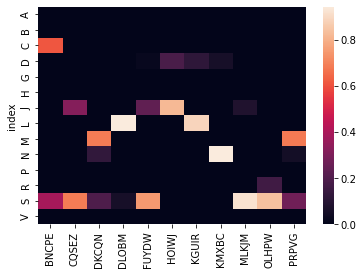

In [30]:
ther_area_df = {'index':list(df['ther_area'].cat.categories)}
for brand in more_than_1_ther_area:
    ther_area_df[brand] = list(df_ther[df_ther['brand']==brand]['ther_area'].value_counts(normalize=True).sort_index())
sns.heatmap(pd.DataFrame(ther_area_df).set_index('index'))

In [31]:
# To visualize how many countries dont share the brand mode of the ther_area
df_ther_check = df_ther_brand[df_ther_brand['brand'].isin(more_than_1_ther_area)]
df_ther_check = df_ther_check.groupby(['brand','country','ther_area']).agg(n_ther=('ther_area','count')).reset_index()
df_ther_check[((df_ther_check['n_ther'] >0)&(df_ther_check['brand'] == 'PRPVG'))]

C:\Users\guill\AppData\Local\Temp\ipykernel_15892\2913372049.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ther_check = df_ther_check.groupby(['brand','country','ther_area']).agg(n_ther=('ther_area','count')).reset_index()


,brand,country,ther_area,n_ther
4208,PRPVG,Aldovia,M,2177
4250,PRPVG,Asgard,M,2067
4264,PRPVG,Atlantis,M,2169
4278,PRPVG,Beleria,M,1103
4292,PRPVG,Braavos,M,1837
4306,PRPVG,Coruscant,M,2153
4324,PRPVG,Dorne,S,842
4334,PRPVG,Elbonia,M,656
4348,PRPVG,Eriador,M,1414
4362,PRPVG,Essos,M,1726


### brands con ther_area candidatas a ser cambiadas

- MLKJM - J -> S - Panem (1/21)
- DLOBM - S -> L - Arendelle y Wakanda (2/24)
- KMXBC - D -> N - Beleria (1/22)
- KGUIR - D -> L - Panem y Aldovia (2/25)
- HOIWJ - J -> D - Westeros (1/5)
- OLHPW - R -> S - Arrakis (1/4)
- CQSEZ - J -> S - Qarth y Aldovia (2/6)
- DKCQN - S -> M - Qarth, Temiscira, Essos (3/17)
- DKCQN - N -> M - Narnia, Panem (2/17)
- BNCPE - S -> C - ['Aldovia','Arrakis','Atlantis','Braavos','Hogwarts','Prydain','Sokovia','Themyscira','Yunkai'] (9/24)
- FUYDW - D -> S - Arendelle (1/23)
- FUYDW - J -> S - Atlantis, Beleria, Coruscant, Gondor, Sokovia, Wakanda (6/23)
- PRPVG - S -> M - Dorne, Etheria, Ferendeln, Gondor, Quarth, Sokovia, Themyscira, Wakanda (8/27)

Given the limited number of drugs with more than one status, we will consider such data as incorrect. This decision is also supported by the fact that no drug in any country is attributed more than one therapeutic area, and it is natural to think that the therapeutic area or areas of a drug are consistent across all countries. That is, what serves to cure a disease X in one country would also work in another, and vice versa. If in another country it serves to cure Y, then in the country where X was cured with the drug, Y can also be cured.

Furthermore, a poor classification of the therapeutic area can lead to maximizing the impact of sales of certain types of drugs (especially those that appear to be majority, like L) or, conversely, to minimizing the impact of sales of a type of drug (as is the case of HOIWJ since D is a very minority therapeutic area that is being imputed to another more majority category, J).

On the other hand, each therapeutic area will be subject to a group of diseases which may be prone to seasonality, such as colds or allergies. An incorrect classification of the therapeutic area will affect the phase and the model that predicts it.

In [32]:
df['ther_area'].value_counts()

ther_area
L    617269
N    377794
C    316495
S    275009
R    187259
M    119680
H    107051
A    106651
V     79445
J     79260
G     35352
B     33690
D     23810
P      4313
Name: count, dtype: int64

In [33]:
nunique_ther

,ther_area
brand,
ABRRE,"['C', NaN] Categories (14, object): ['A', 'B',..."
AIMST,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AITPJ,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AIZTT,"['S', NaN] Categories (14, object): ['A', 'B',..."
AMOKR,"['S', NaN] Categories (14, object): ['A', 'B',..."
...,...
ZKMVW,"['N'] Categories (14, object): ['A', 'B', 'C',..."
ZNDRT,"['V'] Categories (14, object): ['A', 'B', 'C',..."
ZQSPB,"['L', NaN] Categories (14, object): ['A', 'B',..."


In [34]:
# There is 100 over 230 brands which have ther_area = NaN en all its records
nunique_ther = df_ther.groupby('brand').agg({'ther_area':'nunique'})
only_ta_nan = list(nunique_ther[nunique_ther['ther_area'] == 0].index)
only_ta_nan[0:10]

['AIMST',
 'AITPJ',
 'ARBSZ',
 'BFFIN',
 'BQSIJ',
 'BRQJC',
 'BZJGB',
 'CQXPP',
 'CXGRE',
 'DWBKI']

In [35]:
# Brands with a therapeutic area listed as NaN, or with only one non-NaN value, can be reassigned to the non-NaN value
nunique_1 = list(nunique_ther[nunique_ther['ther_area'] == 1].index)
nunique_1

['ABRRE',
 'AIZTT',
 'AMOKR',
 'AMQQS',
 'BBIDC',
 'BELQI',
 'BJZQP',
 'BRBUX',
 'BSZFS',
 'BUMTY',
 'CCXTL',
 'CDFFX',
 'CFCMT',
 'CPHZR',
 'CUEHC',
 'CYUJX',
 'DAPTX',
 'DBEYQ',
 'DDRNC',
 'DKGUK',
 'DKNSS',
 'DRGNL',
 'EAHGQ',
 'EJXYC',
 'EMZJL',
 'EUESX',
 'EUJWP',
 'FIPNP',
 'FLGPE',
 'FQGFS',
 'FTFTW',
 'GFTPG',
 'GIKKL',
 'GUCEF',
 'HGSMA',
 'HHBXR',
 'HIBSM',
 'HJDCK',
 'HPTIP',
 'HRQUR',
 'HTRHP',
 'IBFOZ',
 'ICEII',
 'ICPTW',
 'IDMBR',
 'ILMXM',
 'INOMT',
 'IYPIH',
 'JAZVP',
 'JJVUD',
 'JQKXY',
 'JTOEV',
 'JZIWZ',
 'KCCMS',
 'KJXID',
 'KKZMZ',
 'KVWWC',
 'KXUSS',
 'LCXHV',
 'LESHW',
 'LFJNN',
 'LGFTN',
 'LIIDH',
 'LRHOW',
 'MILBQ',
 'MNZCG',
 'MRHKP',
 'MZCGA',
 'NXPMK',
 'NXPUX',
 'OHQVL',
 'OISZA',
 'OLVUY',
 'OPRCW',
 'ORUVA',
 'OTIVP',
 'PEPBY',
 'PJZBL',
 'PLNDT',
 'PMTEA',
 'PPXOK',
 'PUHXP',
 'QGTFP',
 'QIOFH',
 'QKAPL',
 'QQPNT',
 'QQRPF',
 'QRLJM',
 'QROZQ',
 'QYGNN',
 'QYPXJ',
 'RHXQH',
 'RRGHZ',
 'RUJHO',
 'RXRWV',
 'RYVTJ',
 'SFXLX',
 'SGJLP',
 'SOXJL',
 'SVBEU',


In [36]:
ta_by_brand = df_ther.groupby('brand').agg({'ther_area': 'unique'})
ta_by_brand

,ther_area
brand,
ABRRE,"['C', NaN] Categories (14, object): ['A', 'B',..."
AIMST,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AITPJ,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AIZTT,"['S', NaN] Categories (14, object): ['A', 'B',..."
AMOKR,"['S', NaN] Categories (14, object): ['A', 'B',..."
...,...
ZKMVW,"['N'] Categories (14, object): ['A', 'B', 'C',..."
ZNDRT,"['V'] Categories (14, object): ['A', 'B', 'C',..."
ZQSPB,"['L', NaN] Categories (14, object): ['A', 'B',..."


In [37]:
ta_by_brand.loc['ZVLFE','ther_area'][0]

'M'

In [38]:
rep_dic = {}
ta_by_brand = ta_by_brand[ta_by_brand.index.isin(nunique_1)]

for brand in ta_by_brand.index:
    dfb = df[df['brand'] == brand].copy()  # Copy to avoid SettingWithCopyWarning
    ta_brand = ta_by_brand.loc[brand,'ther_area'][0]
    dfb['ther_area'].fillna(ta_brand, inplace=True)
    df[df['brand'] == brand] = dfb

In [39]:
# Check
df.groupby('brand').agg({'ther_area':'unique'})

,ther_area
brand,
ABRRE,"['C'] Categories (14, object): ['A', 'B', 'C',..."
AIMST,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AITPJ,"[NaN] Categories (14, object): ['A', 'B', 'C',..."
AIZTT,"['S'] Categories (14, object): ['A', 'B', 'C',..."
AMOKR,"['S'] Categories (14, object): ['A', 'B', 'C',..."
...,...
ZKMVW,"['N'] Categories (14, object): ['A', 'B', 'C',..."
ZNDRT,"['V'] Categories (14, object): ['A', 'B', 'C',..."
ZQSPB,"['L'] Categories (14, object): ['A', 'B', 'C',..."


In [40]:
# More than a ther_area dictionary
values_ta = ['C','S','M','L','S','D','L','N','S','S','M']
dicc_ta = dict(zip(more_than_1_ther_area,values_ta))
dicc_ta

{'BNCPE': 'C',
 'CQSEZ': 'S',
 'DKCQN': 'M',
 'DLOBM': 'L',
 'FUYDW': 'S',
 'HOIWJ': 'D',
 'KGUIR': 'L',
 'KMXBC': 'N',
 'MLKJM': 'S',
 'OLHPW': 'S',
 'PRPVG': 'M'}

In [41]:
for key,value in dicc_ta.items():
    dfb = df[df['brand']==key].copy()
    dfb['ther_area'] = value
    df[df['brand']==key].update(dfb)

# Check
df.groupby('brand').agg({'ther_area':'unique'}).loc['OLHPW']

ther_area    ['R', 'S', NaN]
Categories (14, object): ['A',...
Name: OLHPW, dtype: object

### hospital_rate

In [42]:
# Constant across country and brand
df_hr = df.copy()
df_hr_group = df_hr.groupby(['country','brand']).agg({'hospital_rate':'nunique'})
df_hr_group[df_hr_group['hospital_rate']>1]

,,hospital_rate
country,brand,


In [43]:
without_hr = list(df_hr_group[df_hr_group['hospital_rate'] == 0].index)
len(without_hr),without_hr

(730,
 [('Aldovia', 'AIMST'),
  ('Aldovia', 'AITPJ'),
  ('Aldovia', 'AIZTT'),
  ('Aldovia', 'BQSIJ'),
  ('Aldovia', 'BRQJC'),
  ('Aldovia', 'BUMTY'),
  ('Aldovia', 'DKGUK'),
  ('Aldovia', 'DXGSD'),
  ('Aldovia', 'EQZWB'),
  ('Aldovia', 'ESVUF'),
  ('Aldovia', 'EUESX'),
  ('Aldovia', 'FNHPF'),
  ('Aldovia', 'GBWHQ'),
  ('Aldovia', 'GIKKL'),
  ('Aldovia', 'HGXNC'),
  ('Aldovia', 'HJDCK'),
  ('Aldovia', 'HPCEJ'),
  ('Aldovia', 'HZCGL'),
  ('Aldovia', 'IKGEA'),
  ('Aldovia', 'KMXBC'),
  ('Aldovia', 'LCXHV'),
  ('Aldovia', 'LTOHO'),
  ('Aldovia', 'PIIFS'),
  ('Aldovia', 'QSNYX'),
  ('Aldovia', 'QYGNN'),
  ('Aldovia', 'QYPXJ'),
  ('Aldovia', 'RBBLK'),
  ('Aldovia', 'RHXQH'),
  ('Aldovia', 'RUJHO'),
  ('Aldovia', 'RWUKW'),
  ('Aldovia', 'UPRUW'),
  ('Aldovia', 'XUJGO'),
  ('Aldovia', 'YMBRG'),
  ('Aldovia', 'ZVLFE'),
  ('Arendelle', 'AITPJ'),
  ('Arendelle', 'AIZTT'),
  ('Arendelle', 'EUESX'),
  ('Arendelle', 'FJVNL'),
  ('Arendelle', 'GIKKL'),
  ('Arendelle', 'HGXNC'),
  ('Arendelle', 'HJDCK

In [44]:
with_hr = df_hr_group[df_hr_group['hospital_rate'] == 1]
len(with_hr)

1941

In [45]:
# Exploring atypical data values as hr=1

# Check main_channel is unique in this case
df_hr_aux = df_hr[df_hr['hospital_rate']==1].groupby('brand').agg({'main_channel':'nunique'})
df_hr_aux[df_hr_aux['main_channel'] > 1]

,main_channel
brand,


In [46]:
# and equal to HOSPITAL
df_hr_aux = df_hr[df_hr['hospital_rate']==1].groupby('brand').agg({'main_channel':'unique'})
df_hr_aux[df_hr_aux['main_channel'] != 'HOSPITAL']

,main_channel
brand,


In [47]:
# Explore hr = 0 records (nothing interesting)
df_hr[df_hr['hospital_rate']==0]

,year,month,country,brand,phase,dayweek,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
66,2013,1.0,Aldovia,CCXTL,0.003549,2.0,0.045455,G,0.0,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.004018,RETAIL
67,2013,1.0,Aldovia,CCXTL,0.118722,3.0,0.090909,G,0.0,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.004018,RETAIL
68,2013,1.0,Aldovia,CCXTL,0.106291,4.0,0.136364,G,0.0,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.004018,RETAIL
69,2013,1.0,Aldovia,CCXTL,0.035431,0.0,0.181818,G,0.0,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.004018,RETAIL
70,2013,1.0,Aldovia,CCXTL,0.117941,1.0,0.227273,G,0.0,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.004018,RETAIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707956,2021,12.0,Zamunda,UYELK,0.006826,3.0,0.789474,C,0.0,0.0,3.0,4,4,3,5,3,2021-12-23,15,4,0.020175,RETAIL
2707957,2021,12.0,Zamunda,UYELK,0.038958,0.0,0.842105,C,0.0,3.0,0.0,4,4,3,5,3,2021-12-27,16,3,0.020175,RETAIL
2707958,2021,12.0,Zamunda,UYELK,0.003995,1.0,0.894737,C,0.0,0.0,0.0,4,4,3,5,3,2021-12-28,17,2,0.020175,RETAIL
2707959,2021,12.0,Zamunda,UYELK,0.000000,2.0,0.947368,C,0.0,0.0,0.0,4,4,3,5,3,2021-12-29,18,1,0.020175,RETAIL


### Main channel

In [48]:
# Each country and brand has a unique main_channel assigned, with NaN also considered as a main_channel.
# Therefore, there are products and countries to which we cannot impute the value from other records without NaN.
df_mc = df.copy()
df_mc_group = df_mc.groupby(['country','brand']).agg({'main_channel':'unique'})
df_mc_group[df_mc_group['main_channel'].apply(len)>1]

,,main_channel
country,brand,


## Check constraints

### Observation
If we assume that data for all weekdays are present for each country and brand, we can easily recalculate any erroneous temporal data. This assumption is plausible because we have verified that the sum of the phasing is 1, which means that, without negative daily phasing, the only possibility for the number of records not reflecting the number of wd would be:

- that there are records with phasing 0 representing non-working Mondays, Tuesdays, etc.
- or that the phasing >0 was attributed to a non-working day (Monday,..., Friday) while there would be a working day that would have phasing = 0.

Therefore, two dataframes should be extracted over each month and year for each brand and each country:

- One for records with phasing 0 that are nwd
- One for records with phasing 0 that are wd

But this requires the following hypothesis 1: that the columns n_nwd_aft and n_nwd_bef are correct so that the sum (subtraction) of these to the date column plus 1 (minus 1) provide for each day the next working day. Thus, we would have non-working days (other than Saturday and Sunday) between these two dates, and once obtained, we would have to see if any of them are in any record of the df of each country and with what phase.

However, we will assume hypothesis 2: the records comprise all the weekdays of each month and the 'date' column is correct for each record.

Hypothesis 1 will be addressed in another notebook. In this one, we will deal with hypothesis 2.

# Hypothesis 2

In [49]:
matrix = df.groupby(['year','month','country','brand']).agg(first_wd = ('date','min'), last_wd = ('date','max'), n_wd = ('date','count'))
matrix

first_wd    last_wd  n_wd
year month country brand                            
2013 1.0   Aldovia AIMST 2013-01-02 2013-01-31    22
                   AIZTT 2013-01-02 2013-01-31    22
                   BUMTY 2013-01-02 2013-01-31    22
                   CCXTL 2013-01-02 2013-01-31    22
                   CDFFX 2013-01-02 2013-01-31    22
...                             ...        ...   ...
2021 12.0  Zamunda WUOIM 2021-12-02 2021-12-30    19
                   XMLDV 2021-12-02 2021-12-30    19
                   YOWYI 2021-12-02 2021-12-30    19
                   ZHQFB 2021-12-02 2021-12-30    19
                   ZKKLD 2021-12-02 2021-12-30    19

[132075 rows x 3 columns]

In [50]:
df_nwd = df[['year','month','country','brand','date','n_nwd_bef','n_nwd_aft']]
f_n_nwd_bef = matrix.reset_index().merge(df_nwd,left_on=['year','month','country','brand','first_wd'],right_on=['year','month','country','brand','date'],how='left')
f_n_nwd_bef = f_n_nwd_bef[['year','month','country','brand','n_nwd_bef']]
f_n_nwd_bef

,year,month,country,brand,n_nwd_bef
0,2013,1.0,Aldovia,AIMST,4.0
1,2013,1.0,Aldovia,AIZTT,4.0
2,2013,1.0,Aldovia,BUMTY,4.0
3,2013,1.0,Aldovia,CCXTL,4.0
4,2013,1.0,Aldovia,CDFFX,4.0
...,...,...,...,...,...
132070,2021,12.0,Zamunda,WUOIM,1.0
132071,2021,12.0,Zamunda,XMLDV,1.0
132072,2021,12.0,Zamunda,YOWYI,1.0
132073,2021,12.0,Zamunda,ZHQFB,1.0


In [51]:
l_n_nwd_aft = matrix.reset_index().merge(df_nwd,left_on=['year','month','country','brand','last_wd'],right_on=['year','month','country','brand','date'],how='left')
l_n_nwd_aft = l_n_nwd_aft[['year','month','country','brand','n_nwd_aft','n_wd']]
l_n_nwd_aft

,year,month,country,brand,n_nwd_aft,n_wd
0,2013,1.0,Aldovia,AIMST,0.0,22
1,2013,1.0,Aldovia,AIZTT,0.0,22
2,2013,1.0,Aldovia,BUMTY,0.0,22
3,2013,1.0,Aldovia,CCXTL,0.0,22
4,2013,1.0,Aldovia,CDFFX,0.0,22
...,...,...,...,...,...,...
132070,2021,12.0,Zamunda,WUOIM,3.0,19
132071,2021,12.0,Zamunda,XMLDV,3.0,19
132072,2021,12.0,Zamunda,YOWYI,3.0,19
132073,2021,12.0,Zamunda,ZHQFB,3.0,19


In [52]:
n_nwd_matrix = f_n_nwd_bef.merge(l_n_nwd_aft,on=['year','month','country','brand'])
n_nwd_matrix.rename({'n_nwd_bef':'first_n_nwd_bef','n_nwd_aft':'last_n_nwd_aft'},axis=1,inplace=True)
n_nwd_matrix

,year,month,country,brand,first_n_nwd_bef,last_n_nwd_aft,n_wd
0,2013,1.0,Aldovia,AIMST,4.0,0.0,22
1,2013,1.0,Aldovia,AIZTT,4.0,0.0,22
2,2013,1.0,Aldovia,BUMTY,4.0,0.0,22
3,2013,1.0,Aldovia,CCXTL,4.0,0.0,22
4,2013,1.0,Aldovia,CDFFX,4.0,0.0,22
...,...,...,...,...,...,...,...
132070,2021,12.0,Zamunda,WUOIM,1.0,3.0,19
132071,2021,12.0,Zamunda,XMLDV,1.0,3.0,19
132072,2021,12.0,Zamunda,YOWYI,1.0,3.0,19
132073,2021,12.0,Zamunda,ZHQFB,1.0,3.0,19


In [53]:
matrix_2 = df[['year','month','country','brand','date','dayweek','phase','monthly','ther_area','hospital_rate','main_channel']]
matrix = matrix_2.merge(n_nwd_matrix,on=['year','month','country','brand'],how='left').sort_values(['country','brand','date'])
matrix

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082912,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22
1082913,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22
1082914,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22
1082915,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22


In [54]:
matrix['wd'] = df.groupby(['year','month','country','brand']).cumcount()+1
matrix

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082912,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18
1082913,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19
1082914,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20
1082915,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21


In [55]:
matrix['wd_left'] = matrix['n_wd'] - matrix['wd']
matrix

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd,wd_left
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1,21
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2,20
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3,19
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4,18
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082912,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18,4
1082913,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19,3
1082914,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20,2
1082915,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21,1


In [56]:
def detect_nats(date):
    if not pd.isna(date):
        try:
            #Calculate n_nwd_bef
            return date.days - 1
        except:
            #.days return error because date is already an int
            return date
    else:
        return date
    
matrix['n_nwd_bef'] = matrix.groupby(['year','country','month'])['date'].transform(lambda x: x.diff()).apply(detect_nats)
matrix['n_nwd_aft'] = matrix.groupby(['year','country','month'])['n_nwd_bef'].transform(lambda x: x.shift(-1)).apply(detect_nats)
matrix

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd,wd_left,n_nwd_bef,n_nwd_aft
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1,21,NaT,0.0
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2,20,0,0.0
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3,19,0,2.0
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4,18,2,0.0
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5,17,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082912,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18,4,2,0.0
1082913,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19,3,0,0.0
1082914,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20,2,0,0.0
1082915,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21,1,0,0.0


In [57]:
matrix['n_nwd_bef'] = matrix.apply((lambda row: row['first_n_nwd_bef'] if pd.isna(row['n_nwd_bef']) else row['n_nwd_bef']),axis=1)
matrix['n_nwd_aft'] = matrix.apply((lambda row: row['last_n_nwd_aft'] if pd.isna(row['n_nwd_aft']) else row['n_nwd_aft']),axis=1)
matrix

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd,wd_left,n_nwd_bef,n_nwd_aft
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1,21,4.0,0.0
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2,20,0.0,0.0
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3,19,0.0,2.0
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4,18,2.0,0.0
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5,17,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082912,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18,4,2.0,0.0
1082913,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19,3,0.0,0.0
1082914,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20,2,0.0,0.0
1082915,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21,1,0.0,0.0


In [58]:
n_dayweek_df = matrix.groupby(['country','brand','year','month','dayweek']).agg(n_dayweek = ('dayweek','count')).reset_index().drop('brand',axis=1).drop_duplicates()
#pivot table to calculate work days as the existing monday, tuesday records etc.
new_weekday = n_dayweek_df.pivot_table(index=['country','year','month'],values='n_dayweek',columns='dayweek', fill_value=0).reset_index()
new_weekday

dayweek,country,year,month,0.0,1.0,2.0,3.0,4.0
0,Aldovia,2013,1.0,4.0,4.0,5.0,5.0,4.0
1,Aldovia,2013,2.0,4.0,4.0,4.0,4.0,4.0
2,Aldovia,2013,3.0,4.0,4.0,4.0,3.0,4.0
3,Aldovia,2013,4.0,4.0,5.0,4.0,4.0,4.0
4,Aldovia,2013,5.0,3.0,4.0,4.0,5.0,5.0
...,...,...,...,...,...,...,...,...
3109,Zamunda,2021,8.0,5.0,5.0,4.0,4.0,4.0
3110,Zamunda,2021,9.0,4.0,4.0,5.0,5.0,4.0
3111,Zamunda,2021,10.0,4.0,3.0,4.0,4.0,5.0
3112,Zamunda,2021,11.0,4.0,5.0,4.0,4.0,4.0


In [59]:
#Rename new columns
rename_dict = {}
for i in range(0,5):
    rename_dict[i] = f'n_weekday_{i}'
new_weekday = new_weekday.rename(rename_dict,axis=1)

In [60]:
#Update values merging
merge_cols = ['country','year','month']
df_clean = matrix.merge(new_weekday, on=merge_cols, how='left', suffixes=('', '_new'))
df_clean

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd,wd_left,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1,21,4.0,0.0,4.0,4.0,5.0,5.0,4.0
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2,20,0.0,0.0,4.0,4.0,5.0,5.0,4.0
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3,19,0.0,2.0,4.0,4.0,5.0,5.0,4.0
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4,18,2.0,0.0,4.0,4.0,5.0,5.0,4.0
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5,17,0.0,0.0,4.0,4.0,5.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708089,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18,4,2.0,0.0,4.0,4.0,4.0,5.0,5.0
2708090,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19,3,0.0,0.0,4.0,4.0,4.0,5.0,5.0
2708091,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20,2,0.0,0.0,4.0,4.0,4.0,5.0,5.0
2708092,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21,1,0.0,0.0,4.0,4.0,4.0,5.0,5.0


In [61]:
df_clean['wd_perc'] = df_clean['wd'] / df_clean['n_wd']
df_clean

,year,month,country,brand,date,dayweek,phase,monthly,ther_area,hospital_rate,main_channel,first_n_nwd_bef,last_n_nwd_aft,n_wd,wd,wd_left,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,wd_perc
0,2013,1.0,Aldovia,AIMST,2013-01-02,2.0,0.006284,0.008092,NaN,NaN,NaN,4.0,0.0,22,1,21,4.0,0.0,4.0,4.0,5.0,5.0,4.0,0.045455
1,2013,1.0,Aldovia,AIMST,2013-01-03,3.0,0.123459,0.008092,NaN,NaN,NaN,4.0,0.0,22,2,20,0.0,0.0,4.0,4.0,5.0,5.0,4.0,0.090909
2,2013,1.0,Aldovia,AIMST,2013-01-04,4.0,0.055607,0.008092,NaN,NaN,NaN,4.0,0.0,22,3,19,0.0,2.0,4.0,4.0,5.0,5.0,4.0,0.136364
3,2013,1.0,Aldovia,AIMST,2013-01-07,0.0,0.032148,0.008092,NaN,NaN,NaN,4.0,0.0,22,4,18,2.0,0.0,4.0,4.0,5.0,5.0,4.0,0.181818
4,2013,1.0,Aldovia,AIMST,2013-01-08,1.0,0.097054,0.008092,NaN,NaN,NaN,4.0,0.0,22,5,17,0.0,0.0,4.0,4.0,5.0,5.0,4.0,0.227273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708089,2016,9.0,Zamunda,ZVLFE,2016-09-26,0.0,0.010716,0.010540,M,NaN,NaN,0.0,2.0,22,18,4,2.0,0.0,4.0,4.0,4.0,5.0,5.0,0.818182
2708090,2016,9.0,Zamunda,ZVLFE,2016-09-27,1.0,0.042210,0.010540,M,NaN,NaN,0.0,2.0,22,19,3,0.0,0.0,4.0,4.0,4.0,5.0,5.0,0.863636
2708091,2016,9.0,Zamunda,ZVLFE,2016-09-28,2.0,0.051639,0.010540,M,NaN,NaN,0.0,2.0,22,20,2,0.0,0.0,4.0,4.0,4.0,5.0,5.0,0.909091
2708092,2016,9.0,Zamunda,ZVLFE,2016-09-29,3.0,0.065464,0.010540,M,NaN,NaN,0.0,2.0,22,21,1,0.0,0.0,4.0,4.0,4.0,5.0,5.0,0.954545


In [62]:
df_clean.to_parquet('semifinal_df.parquet',engine='pyarrow')

## Second step for handling NaNs

It will involve the use of a machine learning algorithm to replace NaNs with plausible values based on the rest of the data.

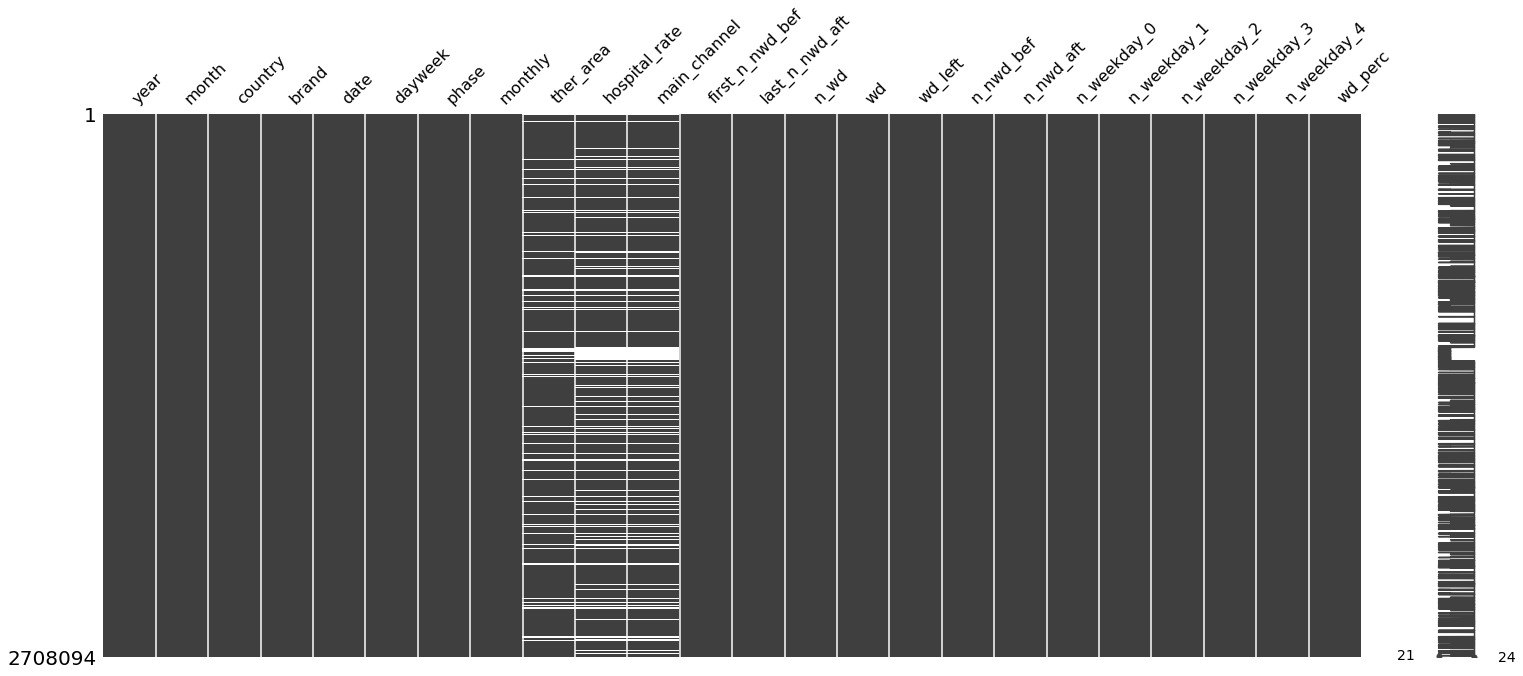

In [63]:
# Turn to NaN to visualize mistakes in n_weekday
df_for_nans = df_clean.copy()
n_weekdays_rep_dic = dict(zip(range(6,16),[np.nan]*len(range(6,16))))
nan_weekday_cols = df_for_nans[n_weekday_cols].replace(n_weekdays_rep_dic)
nan_dayweek_cols = df_for_nans['dayweek'].replace({float(5):np.nan,float(6):np.nan})
df_for_nans[n_weekday_cols] = nan_weekday_cols
df_for_nans['dayweek'] = nan_dayweek_cols
msno.matrix(df_for_nans)
plt.show()